<a href="https://colab.research.google.com/github/NID123-CH/LLM-Codes/blob/main/Fine_Tune_Yoda_SOLVED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate datasets peft trl bitsandbytes matplotlib gdown

  Using cached accelerate-0.30.1-py3-none-any.whl.metadata (18 kB)
  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached peft-0.11.1-py3-none-any.whl.metadata (13 kB)
  Using cached trl-0.8.6-py3-none-any.whl.metadata (11 kB)
  Using cached bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl.metadata (2.2 kB)
  Using cached matplotlib-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
  Using cached safetensors-0.4.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadat

# Exercise

In this exercise, we'll fine-tune Phi-2 to translate sentences from English to the way Yoda talks.

In order to accomplish that, we'll create a "response template", that is, a special token that triggers the translation. We'll use the token `##[YODA]##>` so, whenever it is added at the end of a sentence, the model should complete it with the translated version.

For example, given the prompt:

`There is bacon in the sandwich.##[YODA]##>`

It should complete the sentence like this:

`There is bacon in the sandwich.##[YODA]##>Bacon in the sandwich there is.`

## Yoda

Download the CSV file and load it using [`load_dataset()`](https://huggingface.co/docs/datasets/en/loading). Then, shuffle the dataset and split it into train and test sets ([preprocessing a dataset](https://huggingface.co/docs/datasets/en/process)).

In [ ]:
# Downloads yoda_translation.csv
!gdown 1luZxKTMuV2E6IGoHI9UARdOFGYAOfBMy

In [ ]:
from datasets import load_dataset, Split
dataset = load_dataset(path='csv', data_files='yoda_translation.csv', quotechar='"', split=Split.ALL)
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'yoda'],
        num_rows: 576
    })
    test: Dataset({
        features: ['sentence', 'yoda'],
        num_rows: 144
    })
})

Take a look at one element of the training set. It should have two columns: `sentence` and `yoda` (the translated sentence).

In [ ]:
dataset['train'][0]

{'sentence': 'No cement will hold hard wood.',
 'yoda': 'Hard wood no cement will hold.'}

### Prompt Dataset

Now, let's make it a "prompt dataset" by renaming the columns to `prompt` and `completion` ([preprocessing a dataset](https://huggingface.co/docs/datasets/en/process)).

We'll train the model to take a regular English sentence (the prompt) and produce an output (that is, complete the sentence) with the Yoda translation (completion).

In [ ]:
prompt_yoda = dataset.rename_columns({'sentence': 'prompt', 'yoda': 'completion'})

In [ ]:
prompt_yoda['train'][0]

{'prompt': 'No cement will hold hard wood.',
 'completion': 'Hard wood no cement will hold.'}

## Tokenizer

Use HF's [`AutoTokenizer`](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoTokenizer) to create a tokenizer for `microsoft/phi-2` model.

The parameters for Phi-2 can be found [here](https://huggingface.co/docs/transformers/main/en/model_doc/codegen#transformers.CodeGenTokenizer). Make sure you add a begin of sentence (BOS) and a padding token (`<|pad|>`) as well.

We'll need to pad it on the left side (cause we're generating new words starting on the end - the right side). You can force the tokenizer to pad on the left by using `padding_side="left"`. Moreover, we have to set `use_fast=False` because Phi's tokenizer does not support the fast tokenizer.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

base_model_id = 'microsoft/phi-2'

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_bos_token=True,
    use_fast=False,
    pad_token='<|pad|>'
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Our "Yoda" token isn't any of the expected special tokens (padding, unknown, mask, etc.). It is an *additional special token*. Luckily, there is a method to add such tokens to the tokenizer:

In [ ]:
response_template = '##[YODA]##>'
tokenizer.add_special_tokens({'additional_special_tokens': [response_template]})

len(tokenizer)

50297

In [ ]:
tokenizer.pad_token, tokenizer.eos_token

('<|pad|>', '<|endoftext|>')

### Formatting

Let's build a formatting function that takes both prompt and completion, and inserts a particular string that will be used to trigger the translation. This string is the response template (`##[YODA]##>`) as previously discussed.

The formatting function should produce outputs such as this one:

`There is bacon in the sandwich.##[YODA]##>Bacon in the sandwich there is.`

However, there is one small - yet important - detail to add: we should add the EOS token to the end of the sentence in order to signal to the model that it should stop the generation at that point.

So, the output should really look like this:

`There is bacon in the sandwich.##[YODA]##>Bacon in the sandwich there is.<|endoftext|>`

In [ ]:
def formatting_func(example):
    return f'{example["prompt"]}{response_template}{example["completion"]}' + tokenizer.eos_token

formatting_func(prompt_yoda['train'][0])

'No cement will hold hard wood.##[YODA]##>Hard wood no cement will hold.<|endoftext|>'

Now, we'll write a function that takes a prompt, formats it, and tokenizes it. It should truncate the formatted prompt according to the `max_length` argument and, optionally, pad the formatted prompt up to that length (see here the arguments for [calling](https://huggingface.co/docs/transformers/main/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__) a tokenizer)

In [ ]:
def generate_and_tokenize_prompt(prompt, max_length=128, padding=True):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length" if padding else False,
    )
    return result

# We'll call it WITHOUT padding first
dataset = prompt_yoda['train'].map(lambda v: generate_and_tokenize_prompt(v, padding=False))
dataset = dataset.remove_columns(['prompt', 'completion'])
print(dataset[0])

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

{'input_ids': [50256, 2949, 20534, 481, 1745, 1327, 4898, 13, 50296, 17309, 4898, 645, 20534, 481, 1745, 13, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Perhaps you're wondering where the labels are... as it turns out, the collator will take care of it. We'll be using a collator for completion only, since we're not interested in the regular English sentences that precede our special "Yoda" token.

In [ ]:
from trl import DataCollatorForCompletionOnlyLM
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

dataloader_completion = DataLoader(dataset, batch_size=2, collate_fn=collator)
next(iter(dataloader_completion))

{'input_ids': tensor([[50295, 50295, 50295, 50256,  2949, 20534,   481,  1745,  1327,  4898,
            13, 50296, 17309,  4898,   645, 20534,   481,  1745,    13, 50256],
        [50256,   464,  1705,  7425,  4719,   656, 42537,  9017,    13, 50296,
            35, 47675,   656, 42537,  9017,   262,  1705,  7425,    13, 50256]]), 'attention_mask': tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100, 17309,  4898,   645, 20534,   481,  1745,    13, 50256],
        [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
            35, 47675,   656, 42537,  9017,   262,  1705,  7425,    13, 50256]])}

576


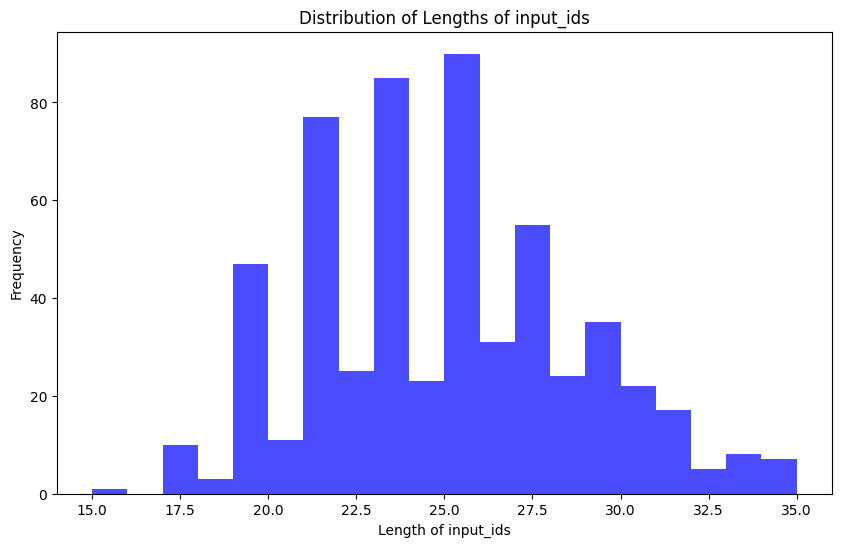

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(dataset)

Now, apply the `generate_and_tokenize_prompt` function to both train and validation sets using the dataset's [`map()`](https://huggingface.co/docs/datasets/en/process#map) method.

You can adjust the max length to better match the observed length of the inputs (in the plot above).

In [ ]:
max_length = 64
tokenized_train_dataset = prompt_yoda['train'].map(lambda v: generate_and_tokenize_prompt(v, max_length))
tokenized_val_dataset = prompt_yoda['test'].map(lambda v: generate_and_tokenize_prompt(v, max_length))

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Try tokenizing (and decoding back) one example from the training set. You should see padding tokens to the left of the sentence, an `<|endoftext|>` token signaling the beginning of the sentence (the same token is used both as BOS and EOS token), the original sentence, our special "Yoda" token, the translated sentence, and the EOS token at the very end.

Here is an example:

`'<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|endoftext|>Quench your thirst, then eat the crackers. ##[YODA]##> Quench your thirst, the crackers then eat.<|endoftext|>'`

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]['input_ids'])

'<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|endoftext|>Quench your thirst, then eat the crackers. ##[YODA]##> Quench your thirst, the crackers then eat.<|endoftext|>'

## Model

Now, let's load the model itself. In order to quantize it while loading it, we need an instance of [`BitAndBytesConfig`](https://huggingface.co/docs/transformers/en/main_classes/quantization#transformers.BitsAndBytesConfig). We can load it in 8-bit using the `NF4` quantization type and double quantization. The computing dtype may be `torch.float16` or - if the GPU supports it - `torch.bfloat16`.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Before moving forward, let's check if the embeddings layer needs resizing or not (since we have added a special token to the tokenizer).

In [ ]:
model.model.embed_tokens, len(tokenizer)
# no need
# model.resize_token_embeddings(len(tokenizer))

(Embedding(51200, 2560), 50297)

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
 

How many trainable parameters are left after we load the quantized model? Which layers can still be trained? Let's check it out:

In [ ]:
def print_trainable_parameters(model, verbose=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if verbose:
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model, verbose=True)

model.embed_tokens.weight
model.layers.0.input_layernorm.weight
model.layers.0.input_layernorm.bias
model.layers.1.input_layernorm.weight
model.layers.1.input_layernorm.bias
model.layers.2.input_layernorm.weight
model.layers.2.input_layernorm.bias
model.layers.3.input_layernorm.weight
model.layers.3.input_layernorm.bias
model.layers.4.input_layernorm.weight
model.layers.4.input_layernorm.bias
model.layers.5.input_layernorm.weight
model.layers.5.input_layernorm.bias
model.layers.6.input_layernorm.weight
model.layers.6.input_layernorm.bias
model.layers.7.input_layernorm.weight
model.layers.7.input_layernorm.bias
model.layers.8.input_layernorm.weight
model.layers.8.input_layernorm.bias
model.layers.9.input_layernorm.weight
model.layers.9.input_layernorm.bias
model.layers.10.input_layernorm.weight
model.layers.10.input_layernorm.bias
model.layers.11.input_layernorm.weight
model.layers.11.input_layernorm.bias
model.layers.12.input_layernorm.weight
model.layers.12.input_layernorm.bias
model.

## LoRA

Quantization makes the model smaller to load, but we still need LoRA to make training faster.

So, we need to create an instance of [`LoraConfig`](https://huggingface.co/docs/peft/main/en/developer_guides/quantization#loraconfig). You need to choose a rank (`r`), the alpha multiplier (`lora_alpha`), the target modules that will be modified by LoRA (`target_modules`), and - optionally - other modules that should be trained and saved (`modules_to_save`).

These extra modules may include layer norm and embeddings modules, for example. Including these modules may deliver better performance but it comes at the cost of not being able to merge multiple adapters together later.

Next, you can use the configuration to get the modified model using `get_peft_model()`.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "dense"
        "fc1", "fc2",
        "lm_head",
    ],
    modules_to_save=['layernorm', 'embed_tokens'],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 146,519,040 || all params: 2,926,202,880 || trainable%: 5.0071


In [ ]:
print_trainable_parameters(peft_model, verbose=True)

base_model.model.model.embed_tokens.modules_to_save.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_A.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_B.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.bias
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight
base_model.mod

## Training

Before actually training the model, we have to configure its training arguments. Hugging Face's `TrainingArguments` is very thorough and comprehensive, so we're providing suggested arguments right away.

It is important to notice that:
- it uses a paged 8-bit optimizer in order to save memory
- it uses gradient accumulation

In [ ]:
# Some Environment Setup
OUTPUT_DIR = "./results/yoda/" # the path to the output directory; where model checkpoints will be saved

In [ ]:
import transformers

training_args = transformers.TrainingArguments(
        output_dir=OUTPUT_DIR,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        auto_find_batch_size=True,
        max_steps=1000,
        learning_rate=2.5e-5,        # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,            # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,              # Save checkpoints every 50 steps
        eval_strategy="steps",       # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="none",
)

The `Trainer` object needs:
- a model (`model` arg)
- a training set (`train_dataset` arg)
- an (optional) validation set (`eval_dataset` arg)
- the training arguments (`args` arg)
- a data collator (`data_collator` arg)

Training may take around 10 minutes in an RTX 3090. In Colab's free version, it will take much longer.

In [ ]:
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=collator
)

trainer.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,3.162800,2.729766
50,2.532500,1.987815
75,1.794400,1.543532
100,1.519800,1.296836
125,1.264500,1.110637
150,1.018600,0.994319
175,0.922400,0.832627
200,0.701000,0.685616
225,0.636800,0.621049
250,0.509300,0.565084


/opt/micromamba/envs/python_310/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/micromamba/envs/python_310/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=1000, training_loss=0.5985516076087951, metrics={'train_runtime': 591.2044, 'train_samples_per_second': 13.532, 'train_steps_per_second': 1.691, 'total_flos': 8183988879360000.0, 'train_loss': 0.5985516076087951, 'epoch': 13.88888888888889})

After 1,000 steps, training loss should be around 0.3. So, we save the trained model to disk.

In [ ]:
model_ckpt = OUTPUT_DIR + "/stop"

trainer.save_model(model_ckpt)

/opt/micromamba/envs/python_310/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


## Reloading the Model

Now, let's reload the trained adapter we have just saved. Remember, it only saves a partial model, so we still need the (quantized) base model.

We can use [`PeftModel.from_pretrained()`](https://huggingface.co/docs/peft/en/package_reference/peft_model#peft.PeftModel.from_pretrained) method to load the fine-tuned model.

In [ ]:
#!gdown 19z2Jn7N-Gek0z1Rhyyh28XDPoIt264vN
#!unzip yoda_adapter.zip -d ./results/yoda/stop

In [ ]:
from peft import PeftModel

fine_tuned_model = PeftModel.from_pretrained(model, model_ckpt)

Now, let's try out our model!

First, we'll "forget" the response template and see how the model reacts:

In [ ]:
eval_prompt = "Luke, I am your father!"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    print(tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.1)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Luke, I am your father!<|endoftext|>


Nothing happened... what if we add the proper response template (`##[YODA]##>`)?

In [ ]:
eval_prompt = "I am your father!"
model_input = tokenizer(eval_prompt+response_template, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    print(tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.1)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I am your father! ##[YODA]##> Your father I am.<|endoftext|>


OK, that's more like it! We got a Yoda-like sentence back!

Let's write a function that handles all the boilerplate for us:

In [ ]:
def generate(model, tokenizer, prompt, response_template="", max_new_tokens=100):
    tokenized_input = tokenizer(prompt+response_template, return_tensors="pt")
    input_ids = tokenized_input["input_ids"].cuda()

    model.eval()
    generation_output = model.generate(
        input_ids=input_ids,
        num_beams=3,
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.1,
        do_sample=True, top_p=0.9,temperature=0.95,
        eos_token_id=tokenizer.eos_token_id,
    )
    output = tokenizer.batch_decode(generation_output, skip_special_tokens=False)[0]
    return output

Now, let's see our new function in action:

In [ ]:
generate(fine_tuned_model, tokenizer, 'The Force is strong in this one.', response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'The Force is strong in this one. ##[YODA]##> Strong in this one the force is.<|endoftext|>'

In [ ]:
generate(fine_tuned_model, tokenizer, 'I am coming home.', response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I am coming home. ##[YODA]##> Coming home I am. Yes, hrrmmm.<|endoftext|>'

In [ ]:
sample = prompt_yoda['test'][1]
generate(fine_tuned_model, tokenizer, sample['prompt'], response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'The glow deepened in the eyes of the sweet girl. ##[YODA]##> Deepened in the eyes of the sweet girl the glow was.<|endoftext|>'

Finally, we can *disable* the LoRA adapter we trained to see how the base model reacts to the sample sentence (with and without the response template):

In [ ]:
with fine_tuned_model.disable_adapter():
    print(generate(fine_tuned_model, tokenizer, sample['prompt']))
    print(generate(fine_tuned_model, tokenizer, sample['prompt'], response_template))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The glow deepened in the eyes of the sweet girl.

"I know," she said, her voice barely above a whisper. "It's like we're two pieces of a puzzle that were meant to fit together."

The man smiled, his heart swelling with love.

"Exactly," he said. "And I'm so grateful that we finally found each other."

They sat in silence for a few moments, lost in their own thoughts.

"You know," the man said, breaking the silence. "I
The glow deepened in the eyes of the sweet girl. ##[YODA]##> ’s words had resonated with her, and she felt a newfound sense of purpose. She was determined to make a difference in the world, and she was ready to take on the challenge.

Theory of Mind Exercises:

1. What was the mood of the sweet girl when she first entered the shop?

Answer: The sweet girl was likely feeling a sense of anticipation and excitement when she first entered the shop. She was eager to learn more about the
